In [201]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
import os
import sys
import cv2
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
sys.path.append("..")

from src.models.unet import UNet
from src.lightning_models.unet_lightning_model import UNetLightningModel
from src.utils.file import get_paths_recursive
from src.config import (
    SKY_FINDER_IMAGES_PATH,
    SKY_FINDER_COVER_PATH,
    UNET_CHECKPOINT_PATH,
    SKY_COVER_HEIGHT,
    SKY_COVER_WIDTH,
    DATA_PATH,
    DEVICE,
    SEED,
)

In [203]:
def enable_dropout(model, dropout_rate=0.5):
    for m in model.modules():
        if isinstance(m, nn.Dropout2d):
            m.p = dropout_rate
            m.train()

def mc_dropout_predictions(model, image, num_samples=20, device='cuda'):
    model.eval()
    enable_dropout(model)
    
    predictions = []
    image = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        for _ in range(num_samples):
            prediction = model(image)
            if isinstance(prediction, dict):
                prediction = prediction["out"]
            
            cloud_pred = torch.sigmoid(prediction[0, 0, :, :]).cpu()
            predictions.append(cloud_pred.unsqueeze(0))
    
    predictions = torch.cat(predictions, dim=0)
    mean_prediction = torch.mean(predictions, dim=0)
    std_prediction = torch.std(predictions, dim=0)
    
    prob_dist = torch.stack([predictions, 1 - predictions], dim=-1)
    mean_prob_dist = torch.mean(prob_dist, dim=0)
    
    entropy_map = -torch.sum(mean_prob_dist * torch.log(mean_prob_dist + 1e-10), dim=-1)
    
    return mean_prediction, std_prediction, entropy_map

def unnormalize(
        image,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ):
    image = image.copy()
    image = image * std + mean
    image = image.clip(0, 1)
    return image

def normalize(
        image,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ):
    image = image.copy()
    image = (image - mean) / std
    return image

def visualize_uncertainty(image, mean_pred, uncertainty, ground_truth = None, uncertainty_type="std"):
    """
    Visualize the input image, ground truth, prediction, and uncertainty
    
    Args:
        image: Input image tensor (C, H, W)
        ground_truth: Ground truth segmentation (H, W)
        mean_pred: Mean prediction (H, W)
        uncertainty: Uncertainty map (H, W)
        uncertainty_type: Type of uncertainty ("std" or "entropy")
    """
    plt.figure(figsize=(20, 5))
    
    # Original image
    plt.subplot(1, 4, 1)
    plt.title("Image")
    plt.imshow(unnormalize(image.numpy().transpose(1, 2, 0)))
    plt.axis("off")
    
    # Mean prediction
    plt.subplot(1, 4, 2)
    plt.title(f"Mean Prediction")
    plt.imshow(mean_pred.numpy(), vmin=0, vmax=1, cmap="bwr")
    plt.axis("off")
    
    # Uncertainty
    plt.subplot(1, 4, 3)
    plt.title(f"Uncertainty ({uncertainty_type})")
    plt.imshow(uncertainty.numpy(), cmap="hot")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")

    if ground_truth is not None:
        # Ground truth
        plt.subplot(1, 4, 4)
        plt.title("Ground Truth")
        plt.imshow(ground_truth.numpy().transpose(1, 2, 0), vmin=0, vmax=1)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [204]:
sky_finder_images_paths = get_paths_recursive(
    folder_path=SKY_FINDER_IMAGES_PATH,
    match_pattern="*.jpg",
    path_type="f",
    recursive=True,
)
print(f"Found {len(sky_finder_images_paths)} images in {os.path.abspath(SKY_FINDER_IMAGES_PATH)}.")
sky_finder_images_locations = [
    "/".join(image_path.split("/")[-3:]) for image_path in sky_finder_images_paths
]

sky_finder_cover_train_images_paths = get_paths_recursive(
    folder_path=f"{SKY_FINDER_COVER_PATH}/train/images",
    match_pattern="*.jpg",
    path_type="f",
    recursive=True,
)
sky_finder_cover_val_images_paths = get_paths_recursive(
    folder_path=f"{SKY_FINDER_COVER_PATH}/val/images",
    match_pattern="*.jpg",
    path_type="f",
    recursive=True,
)
sky_finder_cover_images_paths = sky_finder_cover_train_images_paths + sky_finder_cover_val_images_paths
print(f"Found {len(sky_finder_cover_images_paths)} images in {os.path.abspath(SKY_FINDER_COVER_PATH)}.")
sky_finder_cover_images_locations = [
    "/".join(image_path.split("/")[-3:]) for image_path in sky_finder_cover_images_paths
]

# Remove already labelled images from the list of images to label
new_sky_finder_images_paths = []
for image_path, image_location in zip(sky_finder_images_paths, sky_finder_images_locations):
    if image_location not in sky_finder_cover_images_locations:
        new_sky_finder_images_paths.append(image_path)
print(f"Found {len(new_sky_finder_images_paths)} non-labelled images in {os.path.abspath(SKY_FINDER_IMAGES_PATH)}.")

Found 21495 images in c:\Users\arnau\work\lipid_internship\git\data\sky_finder\images.
Found 240 images in c:\Users\arnau\work\lipid_internship\git\data\sky_finder_cover.
Found 21255 non-labelled images in c:\Users\arnau\work\lipid_internship\git\data\sky_finder\images.


In [205]:
model = UNet(pretrained=True).to(DEVICE)
lightning_model = UNetLightningModel.load_from_checkpoint(
    UNET_CHECKPOINT_PATH,
    model=model,
    learning_rate=0,
    weight_decay=0,
    name="unet",
    dataset="sky_finder_cover",
)
model = lightning_model.model.to(DEVICE)

In [206]:
# shuffle the images
np.random.seed(SEED)
np.random.shuffle(new_sky_finder_images_paths)
for image_path in tqdm(new_sky_finder_images_paths, desc="Processing images..."):
    # Get masked image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SKY_COVER_WIDTH, SKY_COVER_HEIGHT))

    camera_id = image_path.split("/")[-2]
    mask_path = "/".join(image_path.split("/")[:-4]) + f"/masks/{camera_id}.png"
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (SKY_COVER_WIDTH, SKY_COVER_HEIGHT))
    mask = mask > (255 * 0.5)
    mask = np.expand_dims(mask, axis=-1)

    image = np.where(mask, image, 0)
    input_image = normalize(image / 255.0)
    input_image = torch.from_numpy(input_image).float()
    input_image = input_image.permute(2, 0, 1).to(DEVICE)

    # Predict with MC Dropout
    mean_prediction, std_prediction, entropy_map = mc_dropout_predictions(
        model=model,
        image=input_image,
        num_samples=20,
        device=DEVICE,
    )
    
    # visualize_uncertainty(
    #     input_image.cpu(), 
    #     mean_prediction, 
    #     uncertainty=entropy_map,
    #     uncertainty_type="entropy",
    # )

    # save data
    image_save_path = image_path.replace("/sky_finder/", "/sky_finder_active_learning/")
    continuous_prediction_save_path = image_save_path.replace("/images/", "/continuous_predictions/")
    binary_prediction_save_path = image_save_path.replace("/images/", "/binary_predictions/")
    entropy_save_path = image_save_path.replace("/images/", "/entropies/")
    os.makedirs(os.path.dirname(image_save_path), exist_ok=True)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(image_save_path, image)
    os.makedirs(os.path.dirname(continuous_prediction_save_path), exist_ok=True)
    cv2.imwrite(continuous_prediction_save_path, (mean_prediction.cpu().numpy() * 255).astype(np.uint8))
    os.makedirs(os.path.dirname(binary_prediction_save_path), exist_ok=True)
    cv2.imwrite(binary_prediction_save_path, (mean_prediction.cpu().numpy() > 0.5).astype(np.uint8) * 255)
    os.makedirs(os.path.dirname(entropy_save_path), exist_ok=True)
    cv2.imwrite(entropy_save_path, (entropy_map.cpu().numpy() * 255).astype(np.uint8))

Processing images...: 100%|██████████| 21255/21255 [4:33:58<00:00,  1.29it/s]   


Enabling dropout layers for MC Dropout


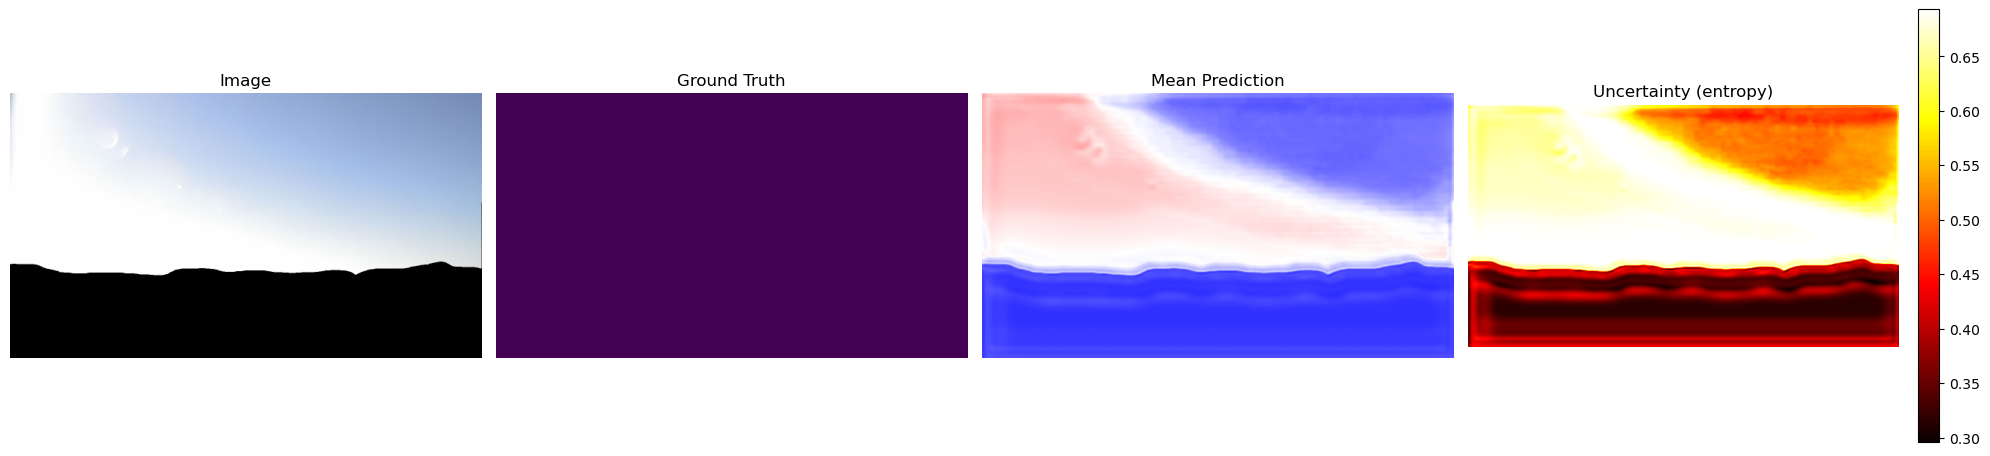

Enabling dropout layers for MC Dropout


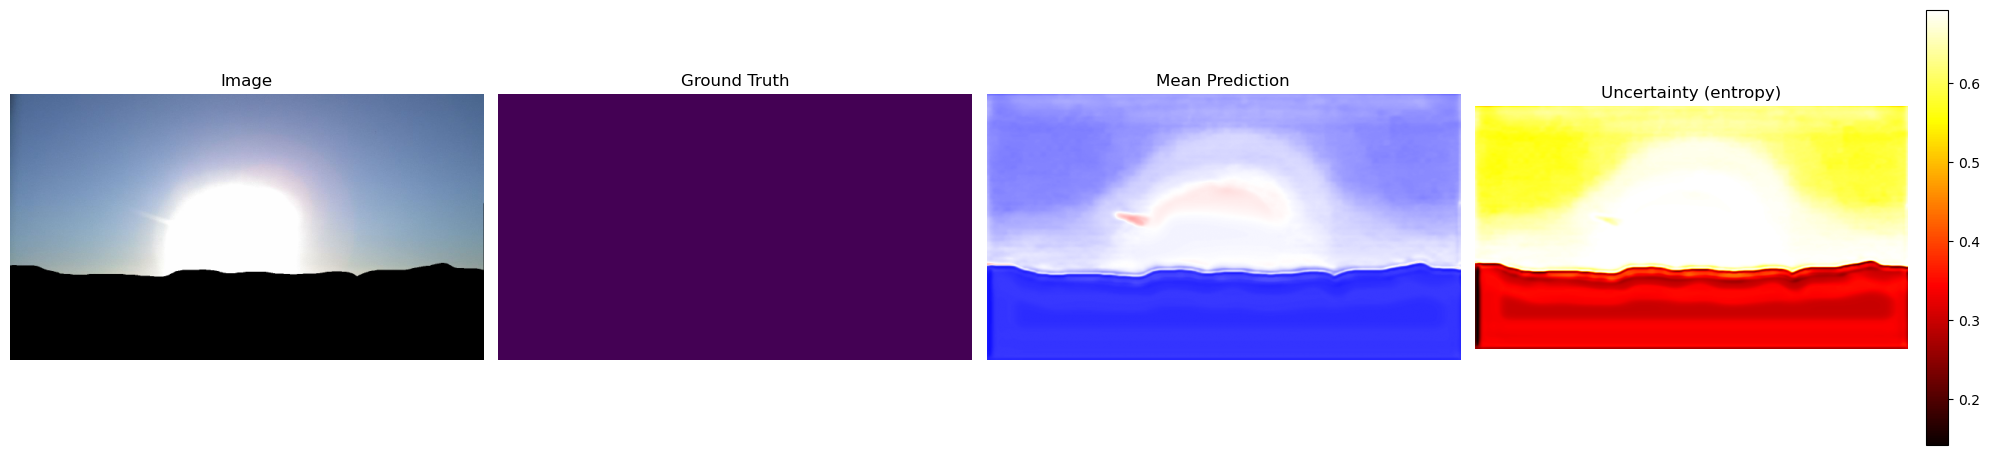

Enabling dropout layers for MC Dropout


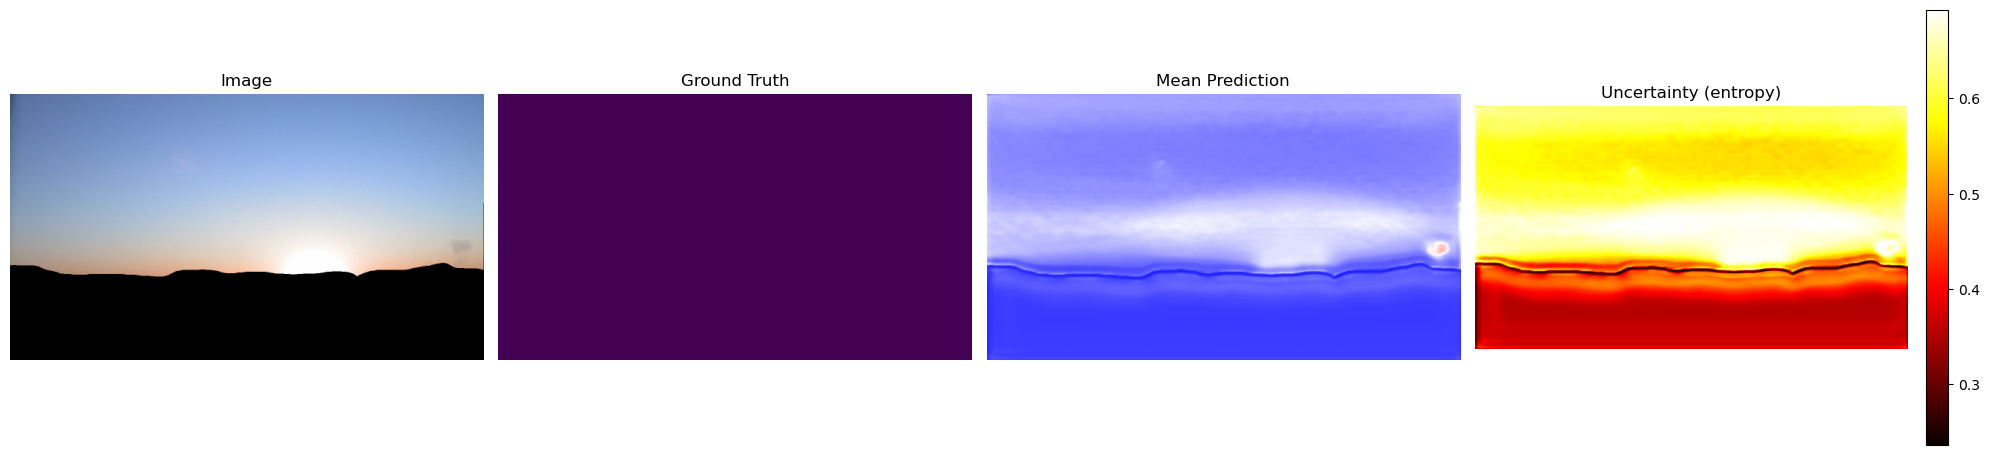

Enabling dropout layers for MC Dropout


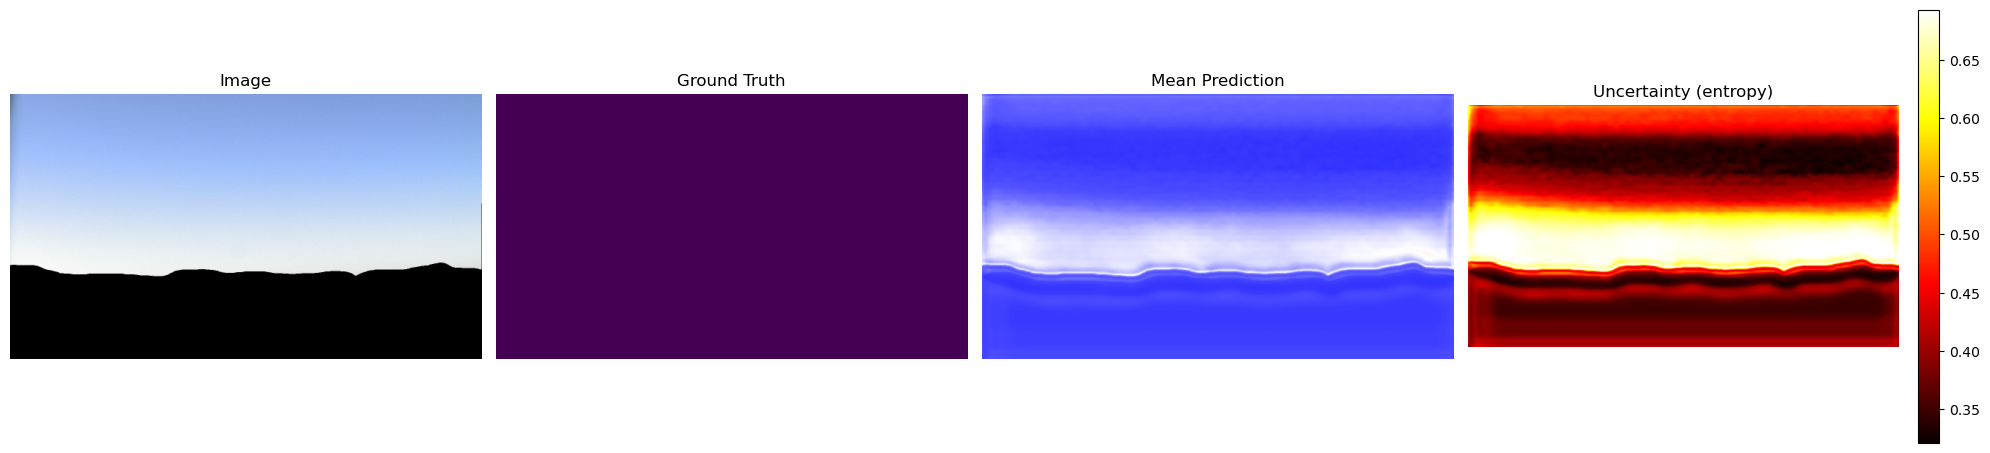

Enabling dropout layers for MC Dropout


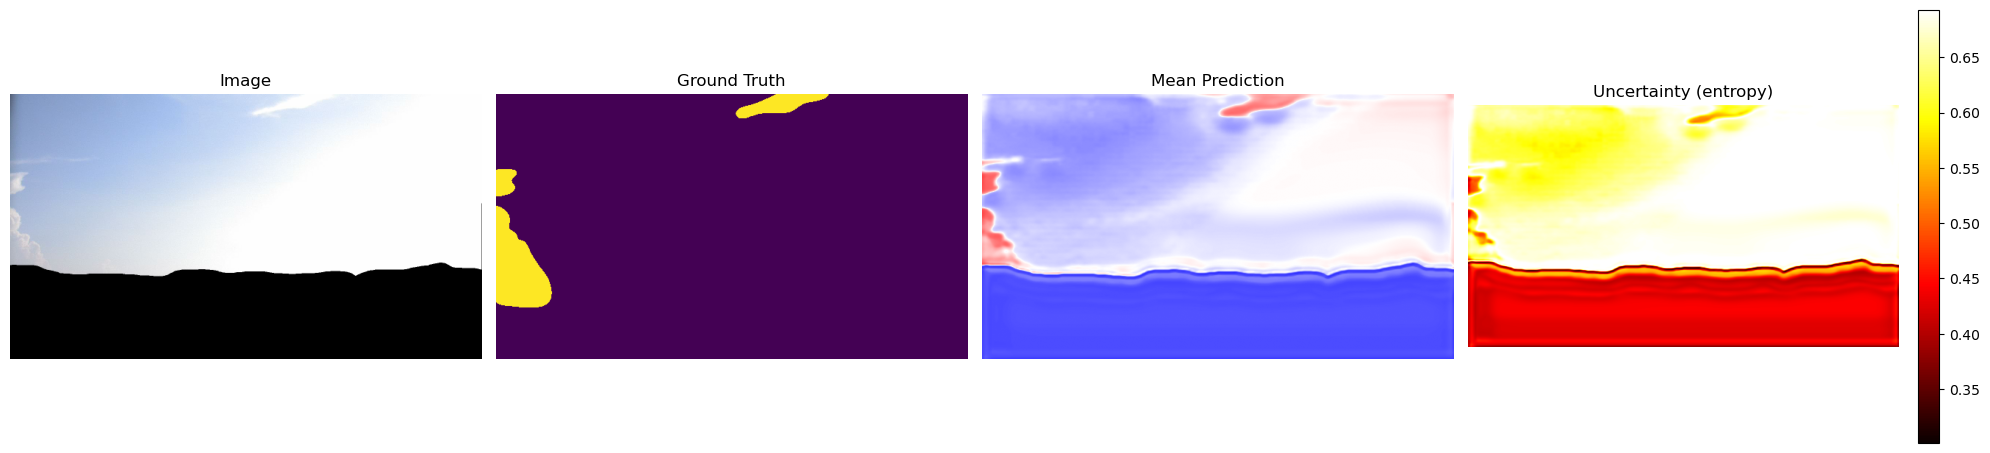

Enabling dropout layers for MC Dropout


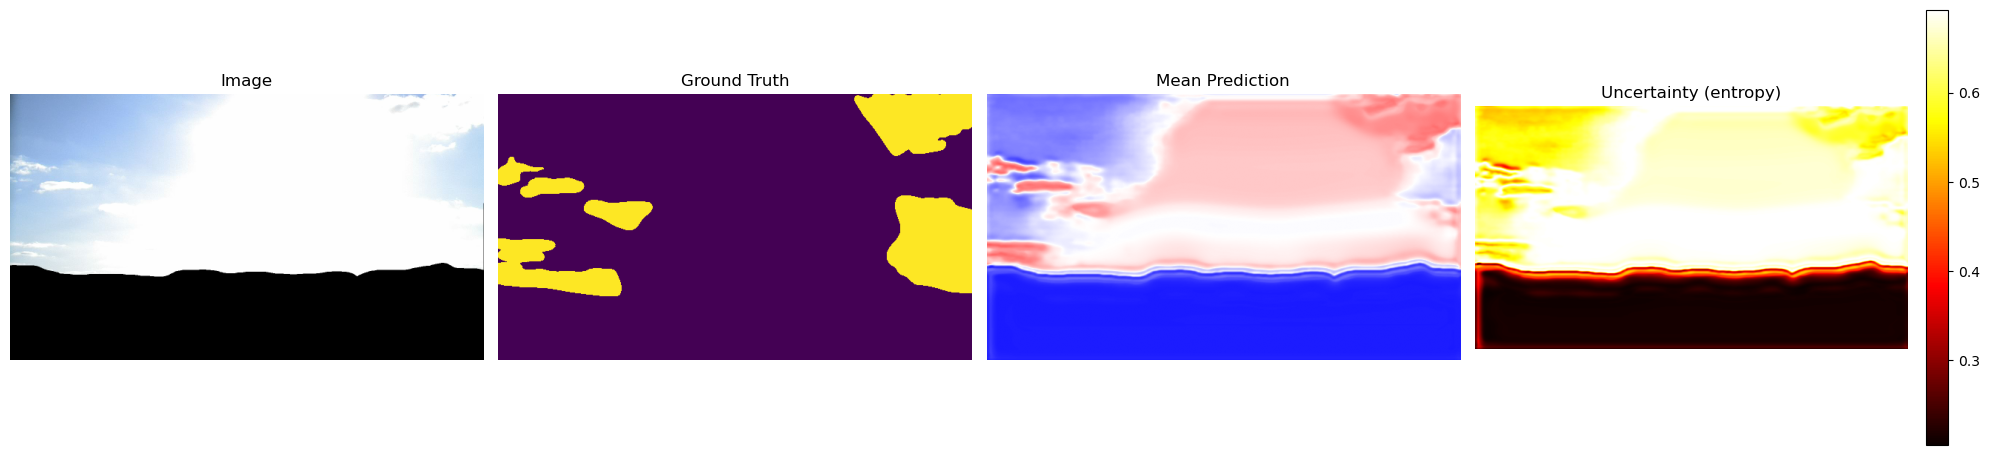

Enabling dropout layers for MC Dropout


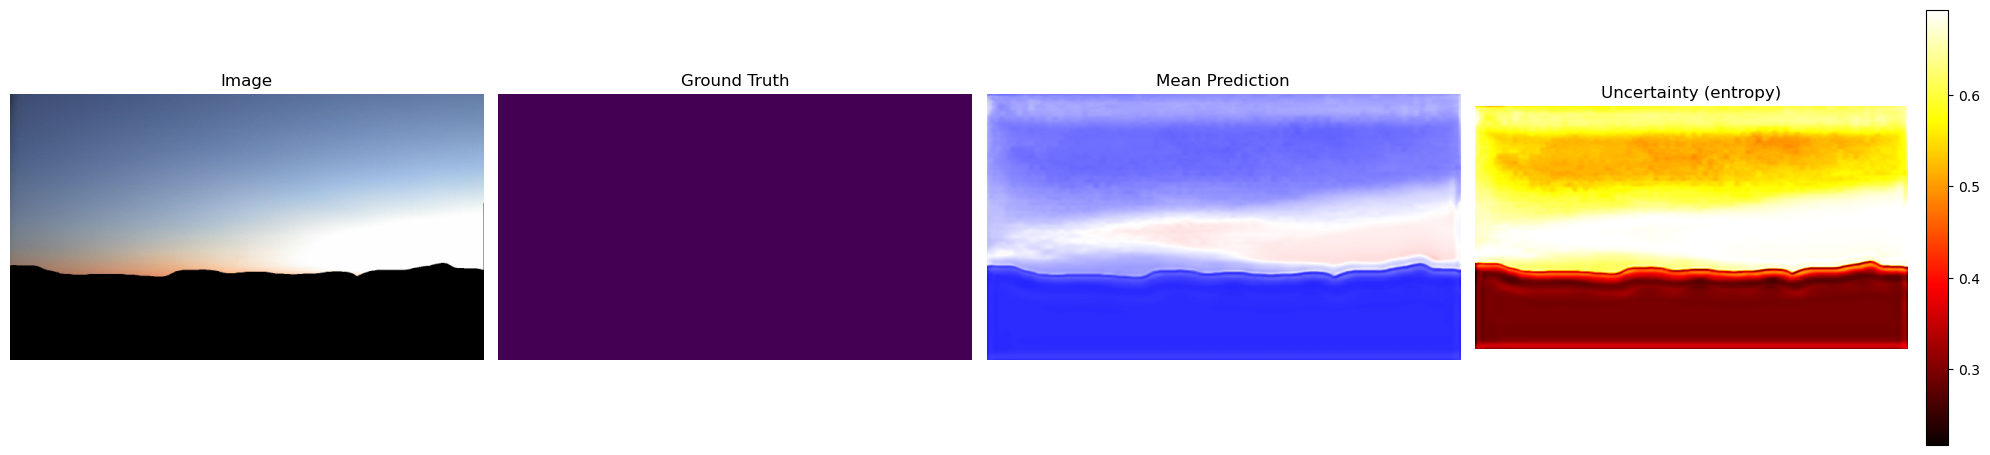

Enabling dropout layers for MC Dropout


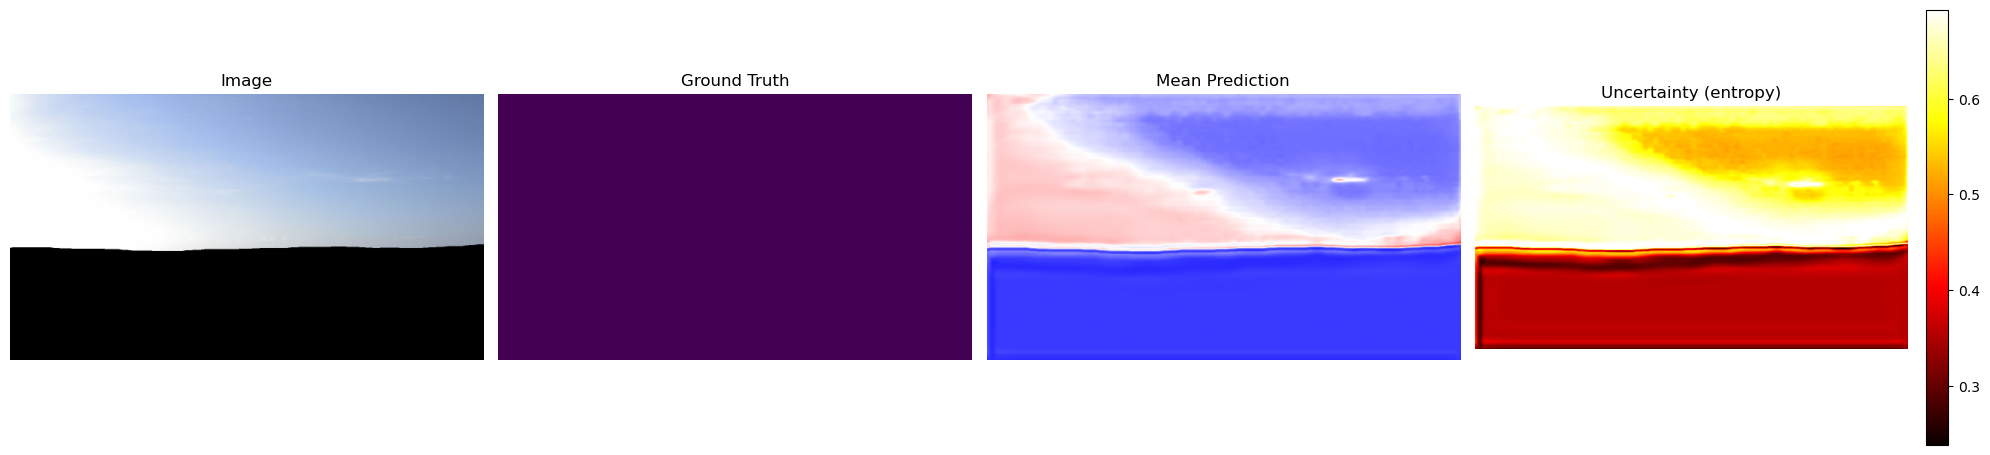

Enabling dropout layers for MC Dropout


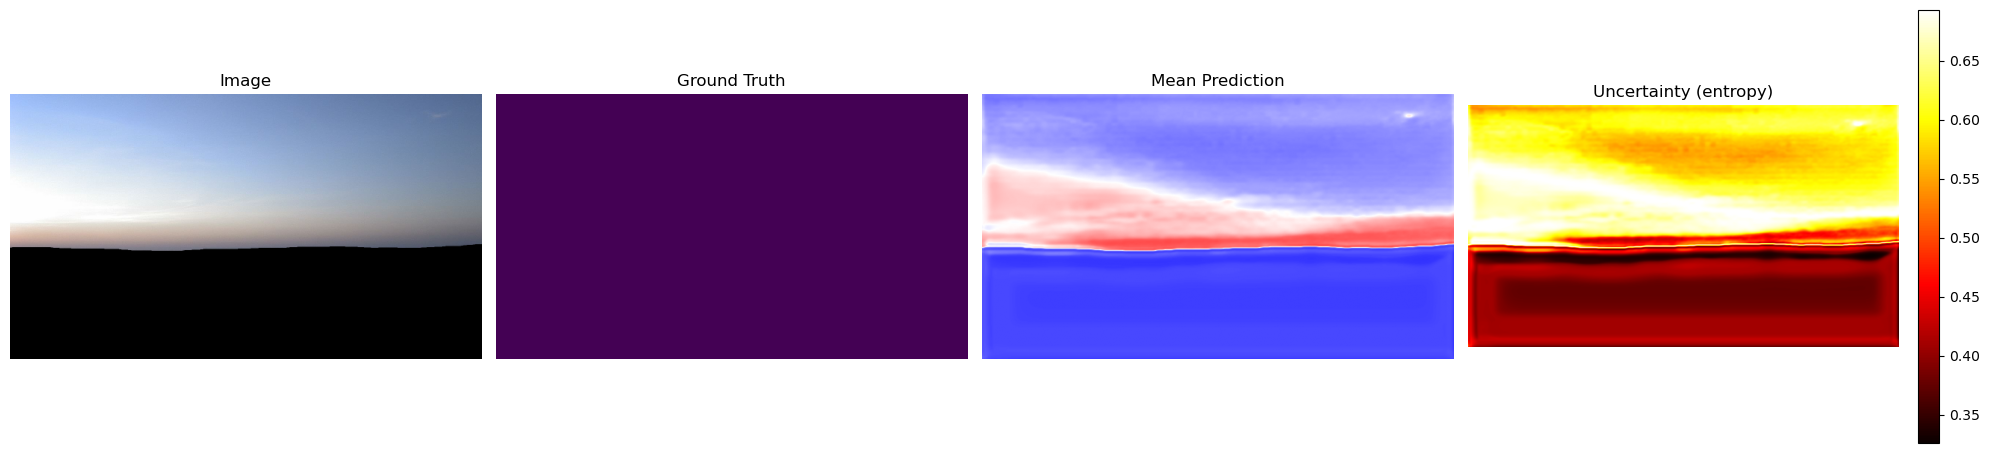

Enabling dropout layers for MC Dropout


KeyboardInterrupt: 

In [60]:
it = iter(val_dataloader)
for batch in it:
    image = batch[0][0]
    cloud_ground_truth = batch[1][0]

    with torch.no_grad():
        prediction = model(image.unsqueeze(0).to(DEVICE))
        cloud_prediction = torch.sigmoid(prediction[0, 0, :, :]).cpu()
        mean_prediction, std_prediction, entropy_map = mc_dropout_predictions(
            model=model,
            image=image,
            num_samples=20,
            device=DEVICE,
        )

        visualize_uncertainty(
            image, 
            cloud_ground_truth, 
            mean_prediction, 
            uncertainty=entropy_map,
            uncertainty_type="entropy",
        )

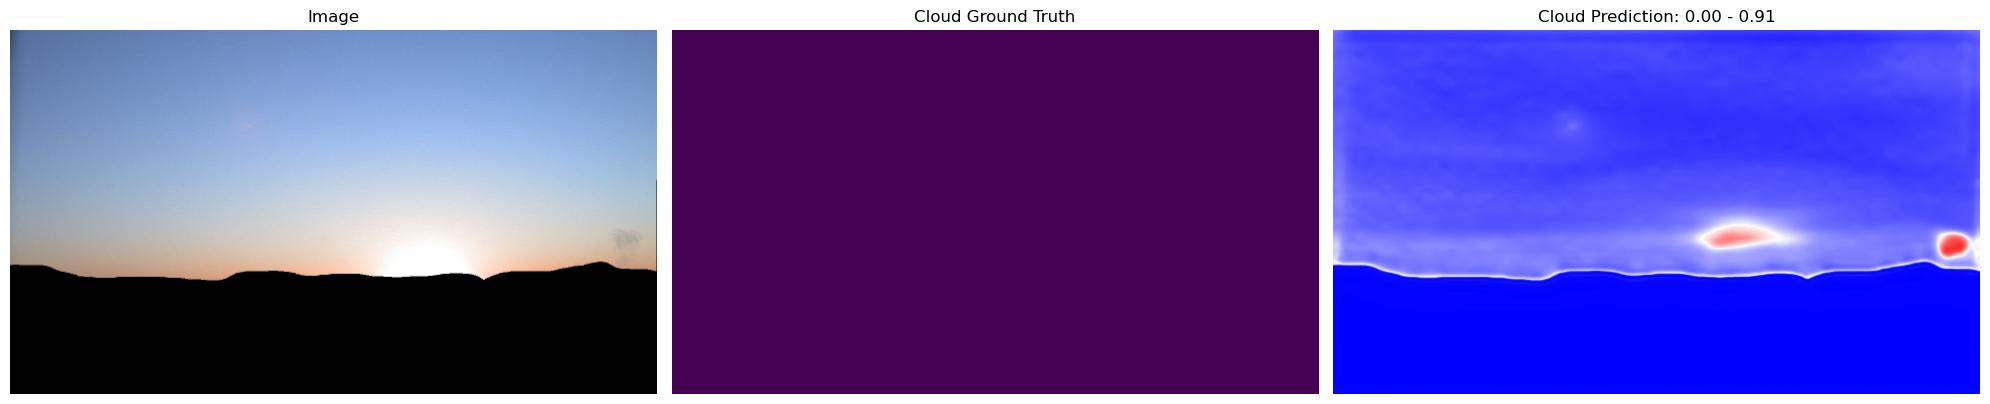

In [10]:
batch = next(it)
image = batch[0][0]
cloud_ground_truth = batch[1][0]
bloom_ground_truth = batch[2][0]

with torch.no_grad():
    prediction = model(image.unsqueeze(0).to(DEVICE))
    if isinstance(prediction, dict):
        prediction = prediction["out"]
    cloud_prediction = prediction[0, 0, :, :].cpu()
    cloud_prediction = torch.sigmoid(cloud_prediction)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(unnormalize(image.numpy().transpose(1, 2, 0)))
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Cloud Ground Truth")
plt.imshow(cloud_ground_truth.numpy().transpose(1, 2, 0), vmin=0, vmax=1)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title(f"Cloud Prediction: {torch.min(cloud_prediction):.2f} - {torch.max(cloud_prediction):.2f}")
plt.imshow(cloud_prediction.numpy(), vmin=0, vmax=1, cmap="bwr")
plt.axis("off")
plt.tight_layout()
plt.show()